In [335]:
import pandas as pd
import numpy as np
from scipy import stats  
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV

In [367]:
#load data
train = pd.read_csv('./train.csv')
#in this version, I think passengerid and name are useless, so i drop them.
train = train.drop(['PassengerId','Name'],axis=1)
trainy = train['Survived']
trainx = train.drop(['Survived'],axis=1)
trainx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Ticket    891 non-null    object 
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 62.8+ KB


[1 2 3]
     pclass_1  pclass_2  pclass_3
0           0         0         1
1           1         0         0
2           0         0         1
3           1         0         0
4           0         0         1
..        ...       ...       ...
886         0         1         0
887         1         0         0
888         0         0         1
889         1         0         0
890         0         0         1

[891 rows x 3 columns]


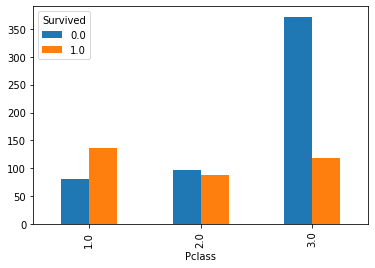

In [346]:
#analyse features————Pclass
print(np.unique(trainx['Pclass'])) # three categories, use one-hot
print(pd.get_dummies(trainx['Pclass'],prefix='pclass'))
# print(train.groupby(['Pclass','Survived'])['Survived'].count())
df = pd.DataFrame(train.groupby(['Pclass','Survived'])['Survived'].count().unstack())
df.plot.bar()
#根据图片可以分析得到：pclass=3的遇难概率更大，而Pclass=2的二者相当，pclass=1的生存概率相对更大，证明该特征是有用的

     female  male
0         0     1
1         1     0
2         1     0
3         1     0
4         0     1
..      ...   ...
886       0     1
887       1     0
888       1     0
889       0     1
890       0     1

[891 rows x 2 columns]


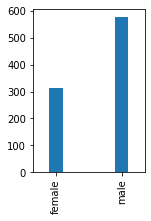

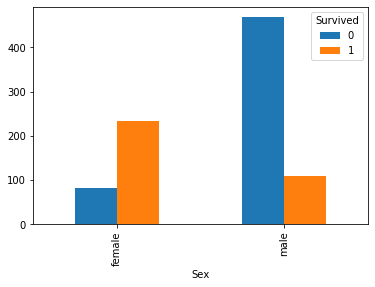

In [54]:
#feature analysis -- Sex
print(pd.get_dummies(train['Sex']))
tempsex = pd.get_dummies(train['Sex'])
#看一下男女比例
np.sum(tempsex).plot.bar(figsize=(2,3),width=0.2)
#看一下存活比例
dfsex = pd.DataFrame(train.groupby(['Sex','Survived'])['Survived'].count().unstack())
dfsex.plot.bar()
#根据图片可以看到，女性的生存比例远大于男性，这个特征是有用的

24.0
80.0 0.42


/Users/jazzychung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


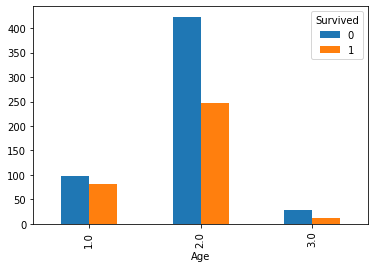

In [136]:
#feature analysis-- age
#由于年龄中存在一定的缺失值，先做填充，这里使用众数进行填充
train.loc[train['Age']<0]=0
mode = stats.mode(np.array(train['Age']))[0][0]
print(mode)
train['Age'][np.isnan(train['Age'])]=mode
#直接分析年龄不切实际，可以年龄进行分段，先查看范围[0.42--80]
print(np.max(train['Age']),np.min(train['Age']))
#故将年龄分为3段0-20/21-55/56-
train['Age'].loc[train['Age']<=20]=1
train['Age'].loc[train['Age']>=55]=3
train['Age'].loc[train['Age']>20]=2
# print(train)
#先看一下年龄分布
dfage = pd.DataFrame(train.groupby(['Age','Survived'])['Survived'].count().unstack())
dfage.plot.bar()
#从图中可知，青年人的生存概率相对较高，但是这个是粗粒度，粒度更细的时候结果可能会不一样，修改了一下发现年纪越小，生还的比率会提高，有意义的特征

SibSp
0    0.654605
1    0.464115
2    0.535714
3    0.750000
4    0.833333
5    1.000000
8    1.000000
dtype: float64


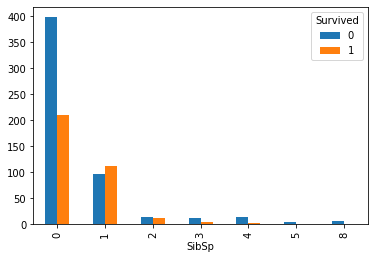

In [151]:
#feature analysis-- sibsp
#sibsp这个属性没有空值，这个属性的意思是sibling&spouse（兄弟姐妹/配偶）根据kaggle的讨论区，sibsp和parch有可能是错误的，如何处理？在初始版本中我先不处理
dfsibsp = pd.DataFrame(train.groupby(['SibSp','Survived'])['Survived'].count().unstack())
dfsibsp = dfsibsp.fillna(0)
print(dfsibsp[0]/(dfsibsp[1]+dfsibsp[0]))#计算一下死亡比
dfsibsp.plot.bar()
#无论从占比还是图片可以看出，最大概率生存下来的，是sibsp=1。其余的死亡占比都很高，而且由于大部分都是0/1，所以这个特征怎么用还得斟酌

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
dtype: float64


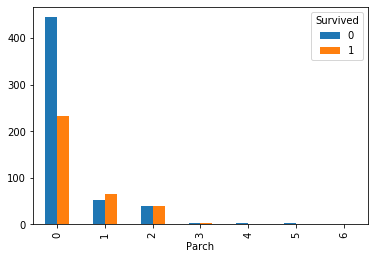

In [154]:
#feature analysis-- parch parent&children
#看一下分布图
dfparch = pd.DataFrame(train.groupby(['Parch','Survived'])['Survived'].count().unstack())
dfparch = dfparch.fillna(0)
print(dfparch[1]/(dfparch[0]+dfparch[1]))#看一下生还率
dfparch.plot.bar()
#可以看出，parch为1-3时生还概率是最高的，因为有孩子的生还的概率更大，但是孩子更多时不好分析
'''
高阶分析：因为parch是包括了双亲和孩子，可以进一步分开，双亲和孩子的概率，但是这个实现需要人工干预，例如分析名字等不好实现。
具体思路：先从年龄小于20的人开始分析，通过比对字符串找到最可能的双亲，同时统计两人的存活状态。
'''


ticketType
1    0.650000
2    0.464286
3    0.361146
dtype: float64


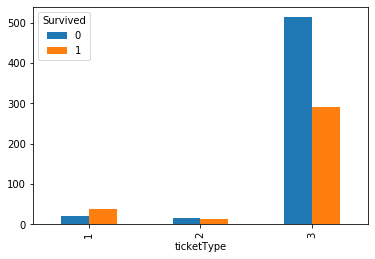

In [273]:
#feature analysis --tickets
#看得出ticket有一些规律，如开头的PC C.A./CA A./5. 还有一些是单纯的数字，开头的字母组合只要分析个别的就可以，不用都分析出来【虽然理论上可以】
#任务1:将ticket列取出，只是方便分析
tkarr = np.array(train['Ticket'])
#任务2:统计开头为PC/ CA中survived的比率
respc = [re.match(r'pc',it,flags=re.I) for it in tkarr]
pcind = [i for i,it in enumerate(respc) if it] #获取特定表达式的index
resca = [re.match(r'c(.)a(.)',it,flags=re.I) for it in tkarr]
caind = [i for i,it in enumerate(resca) if it]
#任务3:画图，特殊票根开头的生还情况柱状图 给一个列PC=1，CA=2，other=3
traintemp = train
traintemp['ticketType']='3'
traintemp['ticketType'].loc[pcind]=1
traintemp['ticketType'].loc[caind]=2
dftick = pd.DataFrame(traintemp.groupby(['ticketType','Survived'])['Survived'].count().unstack())
dftick.plot.bar()
print(dftick[1]/(dftick[0]+dftick[1]))
#通过分析可以看到，PC开头的票存活率最大，ca次之，暂时先这样分，以后再挖掘其他规律

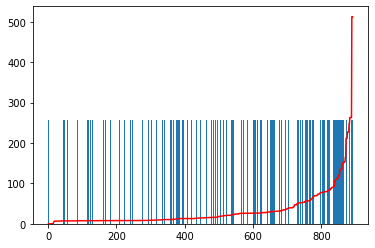

In [293]:
#feature analysis -- fare
# print(np.array(train['Fare']))
#因为是一些数值，暂时先不做区间划分，因为没有缺失值，所以不做处理了
#先按照票价排个序
sorted_train = train.sort_values(by='Fare')
x = np.linspace(1,train.shape[0],train.shape[0])
y1 = sorted_train['Fare']
y2 = sorted_train['Survived']*0.5*max(y1) #大概处理一下让存活状况更好表示
plt.figure()
plt.plot(x,y1,color='r')
plt.bar(x,y2)
plt.show()
#从图像上大概可以看到，fare越高存活的概率相对更大，但是怎么利用起来是个问题

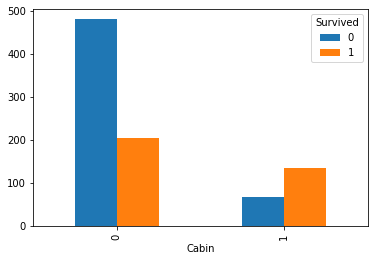

In [316]:
#feature analysis -- cabin
#因为cabin的缺失值很多，可以选择直接丢弃，或者看看有cabin和没cabin的区别
# print(np.array(train['Cabin']))
temp = train['Cabin'].fillna(0)
nonzind = np.nonzero(np.array(temp))
temp[nonzind[0]]=1
train['Cabin'] = temp
dfcab = pd.DataFrame(train.groupby(['Cabin','Survived'])['Survived'].count().unstack())
dfcab.plot.bar()
#可以看出来有cabin号的明显存活率比没有的要高

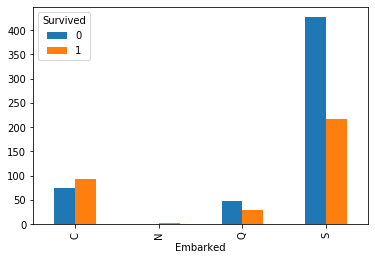

In [331]:
#feature analysis -- embarked 表示登船港口地点
train['Embarked'] = train['Embarked'].fillna('N')
dfem = pd.DataFrame(train.groupby(['Embarked','Survived'])['Survived'].count().unstack())
dfem.plot.bar()
#在Cherbourg登船的客人存活率最高

In [380]:
#以上特征分析完成了开始构建特征
#pclass
temp = pd.get_dummies(trainx['Pclass'],prefix='pclass')
result = pd.concat([train,temp],axis=1)
result = result.drop(['Pclass'],axis=1)
#sex
temp = pd.get_dummies(trainx['Sex'])
result = pd.concat([result,temp],axis=1)
result = result.drop(['Sex'],axis=1)
#age
result['Age'].loc[result['Age']<=20]=1
result['Age'].loc[result['Age']>=55]=3
result['Age'].loc[result['Age']>20]=2
temp = pd.get_dummies(result['Age'],prefix='age')
result = pd.concat([result, temp],axis=1)
result = result.drop(['Age'],axis=1)
print(result)

     Survived  SibSp  Parch            Ticket     Fare Cabin Embarked  \
0           0      1      0         A/5 21171   7.2500   NaN        S   
1           1      1      0          PC 17599  71.2833   C85        C   
2           1      0      0  STON/O2. 3101282   7.9250   NaN        S   
3           1      1      0            113803  53.1000  C123        S   
4           0      0      0            373450   8.0500   NaN        S   
..        ...    ...    ...               ...      ...   ...      ...   
886         0      0      0            211536  13.0000   NaN        S   
887         1      0      0            112053  30.0000   B42        S   
888         0      1      2        W./C. 6607  23.4500   NaN        S   
889         1      0      0            111369  30.0000  C148        C   
890         0      0      0            370376   7.7500   NaN        Q   

     pclass_1  pclass_2  pclass_3  female  male  age_1.0  age_2.0  age_3.0  
0           0         0         1       0     

/Users/jazzychung/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
